In [1]:
import pandas as pd
from datetime import *
from dateutil import parser
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import os

original_weights = pd.read_csv(os.path.join(os.sep, 'tmp','tradeexecutor','all_by_symbol.csv')).sort_values(by='log_time')
original_weights['log_time'] = original_weights['log_time'].apply(parser.parse)

In [2]:
weights = original_weights[original_weights['log_time']>datetime(2022,6,24,tzinfo=timezone.utc)]

weights['total_bps'] = weights['slippage_bps'] + weights['fee']
weights['fee_USD'] = weights['fee']
weights['slippage_USD'] = weights['slippage_bps']*weights['filledUSD']/10000
weights['total_USD'] = weights['total_bps']*weights['filledUSD']/10000

### cumulative slippage and fees

In [3]:
trackrecord = weights[weights['index']=='average'].pivot_table(index='log_time',values=['fee_USD','slippage_USD','total_USD'],aggfunc=sum).cumsum()

In [4]:
trackrecord.iplot()

### slippage distribution

<AxesSubplot:>

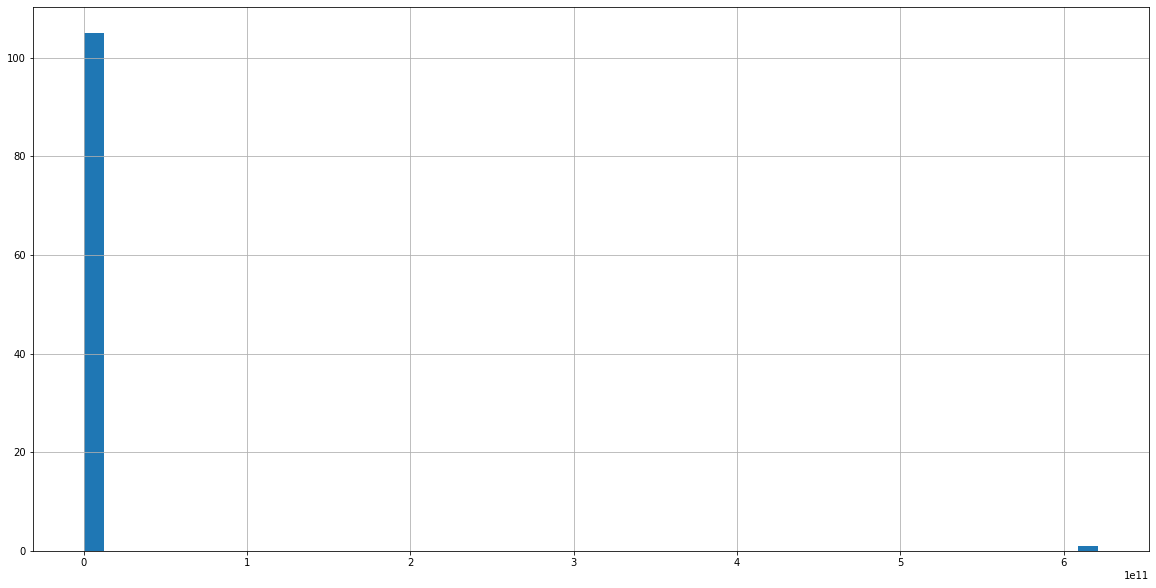

In [5]:
(weights.loc[weights['index']=='average','total_bps']).hist(bins=50,figsize=(20,10))